<a href="https://colab.research.google.com/github/amtaylo/Machine-Learning/blob/master/stock_predictions_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stocks Analysis with Pandas and Scikit-Learn

In [66]:
import pandas as pd
import numpy as np
import datetime
import math
import seaborn as sns
import yellowbrick as yb
from sklearn.preprocessing import scale
import pandas_datareader.data as web
from pandas import Series, DataFrame
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 9, 1)

df = web.DataReader('PG', 'yahoo', start, end)
df["Date"] = df.index
print(df.shape)
print(df.describe())

(1174, 7)
              High          Low  ...        Volume    Adj Close
count  1174.000000  1174.000000  ...  1.174000e+03  1174.000000
mean     87.399574    86.328075  ...  9.214873e+06    81.031741
std       9.933829     9.820027  ...  7.091356e+06    12.040064
min      68.300003    65.019997  ...  2.196700e+06    59.879585
25%      81.044998    80.102499  ...  6.331975e+06    73.081543
50%      85.900002    84.955002  ...  7.734300e+06    78.839966
75%      91.425001    90.367502  ...  9.785500e+06    85.440363
max     122.000000   120.320000  ...  1.237357e+08   121.400002

[8 rows x 6 columns]


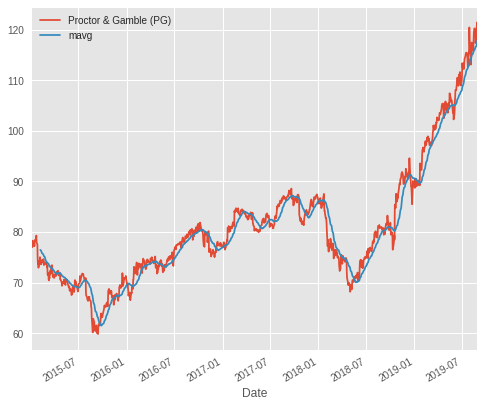

In [67]:
#Create rolling moving averages
close_px = df['Adj Close']
mavg = close_px.rolling(window=25).mean()

#Plot raw price data against moving average
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='Proctor & Gamble (PG)')
mavg.plot(label='mavg')
plt.legend()


##Feature Engineering

We will use these three machine learning models to predict our stocks: Simple Linear Analysis

In [68]:
#Create two features High Low Percentage and Percentage Change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
print(dfreg.head())

            Adj Close     Volume    HL_PCT  PCT_change
Date                                                  
2015-01-02  77.741234  7251400.0  1.194164   -0.440328
2015-01-05  77.371643  8626100.0  1.277637   -0.243823
2015-01-06  77.019203  7791200.0  1.450888   -0.786180
2015-01-07  77.423218  5986600.0  0.899306    0.144538
2015-01-08  78.308563  6823300.0  1.207471    0.685229


##Pre-processing
We will clean up and process the data before putting them into the prediction models

In [69]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want predict stock price 30 days out
forecast_out = 30
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]
print(X[:3])
print(y[:3])

[[-0.27341299 -0.27700061 -0.06511478 -0.57376548]
 [-0.30412282 -0.08306227  0.06245419 -0.33322503]
 [-0.33340756 -0.20084733  0.32722482 -0.99712001]]
[74.00862122 74.6752243  73.76624298]


##Build Training and Test Datasets

***Simple Linear Regression, Ridge, annd Lasso***

In [70]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

#Split data into training and test data sets with a test size of 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Linear Regression
reg = LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)

# Ridge Regression
rdg = Ridge(alpha=.01)
rdg.fit(X_train, y_train)

# Ridge Regression
lss = Lasso(alpha=.01)
lss.fit(X_train, y_train)






Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

##Model Evaluation

In [71]:
confidencereg = reg.score(X_test, y_test)
confidencerdg = rdg.score(X_test,y_test)
confidencelss = lss.score(X_test,y_test)

# results
print('The linear regression confidence is ', str(confidencereg))
print('The ridge regression confidence is ', str(confidencerdg))
print('The lasso regression confidence is ', str(confidencelss))

The linear regression confidence is  0.8525256932722416
The ridge regression confidence is  0.8525258071664767
The lasso regression confidence is  0.852569700576343


##Plotting the Prediction

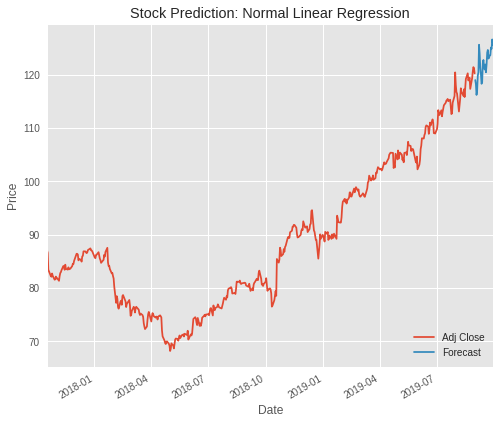

(1204, 6)


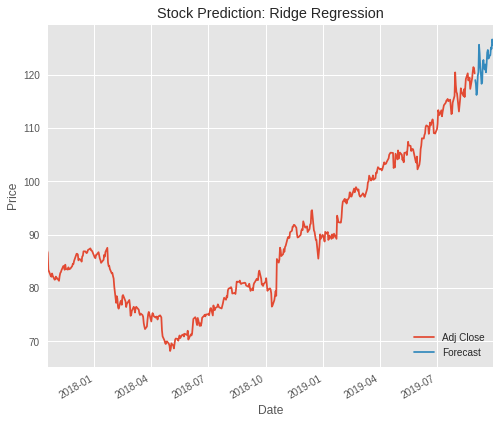

(1204, 6)


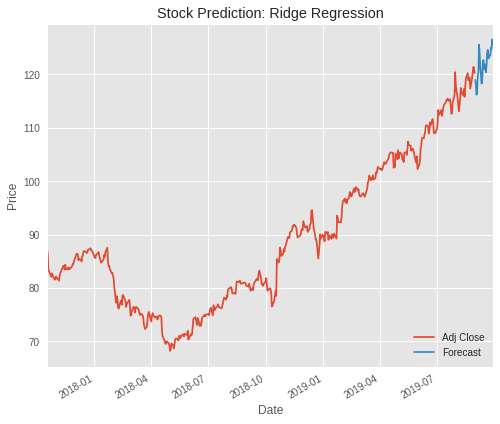

(1204, 6)


In [72]:


def plot_frcst(frcst,dff,ttl):
  
  dfreg['Forecast'] = np.nan

  last_date = dfreg.iloc[-1].name
  last_unix = last_date
  next_unix = last_unix + datetime.timedelta(days=1)

  for i in frcst:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dff.loc[next_date] = [np.nan for _ in range(len(dff.columns)-1)]+[i]
  dff['Adj Close'].tail(500).plot()
  dff['Forecast'].tail(500).plot()
  plt.legend(loc=4)
  plt.title(ttl)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.show()
  
    
ttl="Stock Prediction: Normal Linear Regression"
forecast_reg = reg.predict(X_lately)
plot_frcst(forecast_reg,dfreg,ttl)
print(dfreg.shape)

ttl="Stock Prediction: Ridge Regression"
forecast_rdg = rdg.predict(X_lately)
dfreg = dfreg[:-forecast_out]
plot_frcst(forecast_rdg,dfreg,ttl)
print(dfreg.shape)

ttl="Stock Prediction: Ridge Regression"
forecast_lss = lss.predict(X_lately)
dfreg = dfreg[:-forecast_out]
plot_frcst(forecast_lss,dfreg,ttl)
print(dfreg.shape)


